In [ ]:

# Lung Cancer Detection in Machine Learning
# Model Selection: Decision Tree, SVM, Random Forest 


In [52]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [53]:
# Load the dataset
train = pd.read_csv('data_lung_cancer.csv')

# Preview
train.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [54]:
# Strip column names (some have trailing spaces like 'FATIGUE ')
train.columns = train.columns.str.strip()

# Encode categorical feature
train['GENDER'] = train['GENDER'].map({'M':0, 'F':1})
train['LUNG_CANCER'] = train['LUNG_CANCER'].map({'NO':0, 'YES':1})

# Preview
train.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,0,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,0,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1
2,1,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0
3,0,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0
4,1,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0


In [55]:
# Split dataset - Seprate features and target
X = train.drop('LUNG_CANCER', axis = 1)
y = train['LUNG_CANCER']

# Fill missing values with mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split into train/test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, 
    y, 
    test_size=0.3, 
    random_state=42
)

In [ ]:
# Train & Evaluate ML Models


✅ Model Accuracy: 51.26%

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.51      0.48       445
           1       0.56      0.52      0.54       548

    accuracy                           0.51       993
   macro avg       0.51      0.51      0.51       993
weighted avg       0.52      0.51      0.51       993

Cross-Validation Accuracy: 55.09%


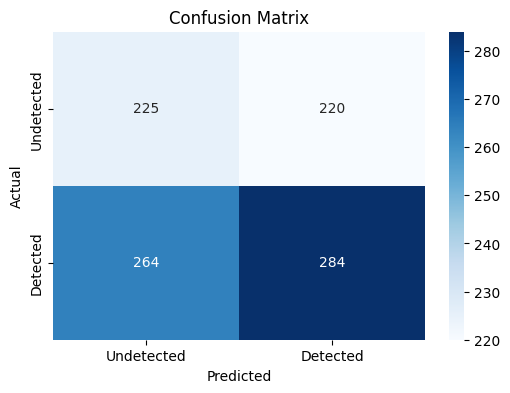

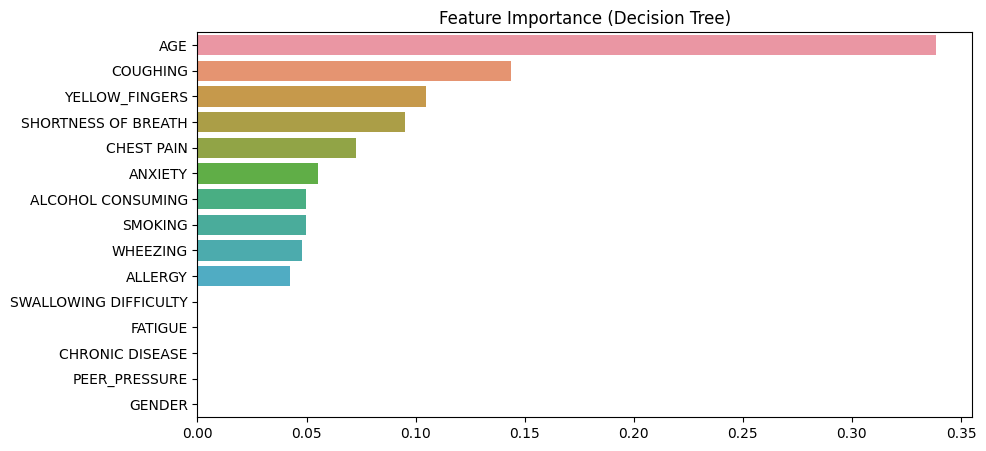

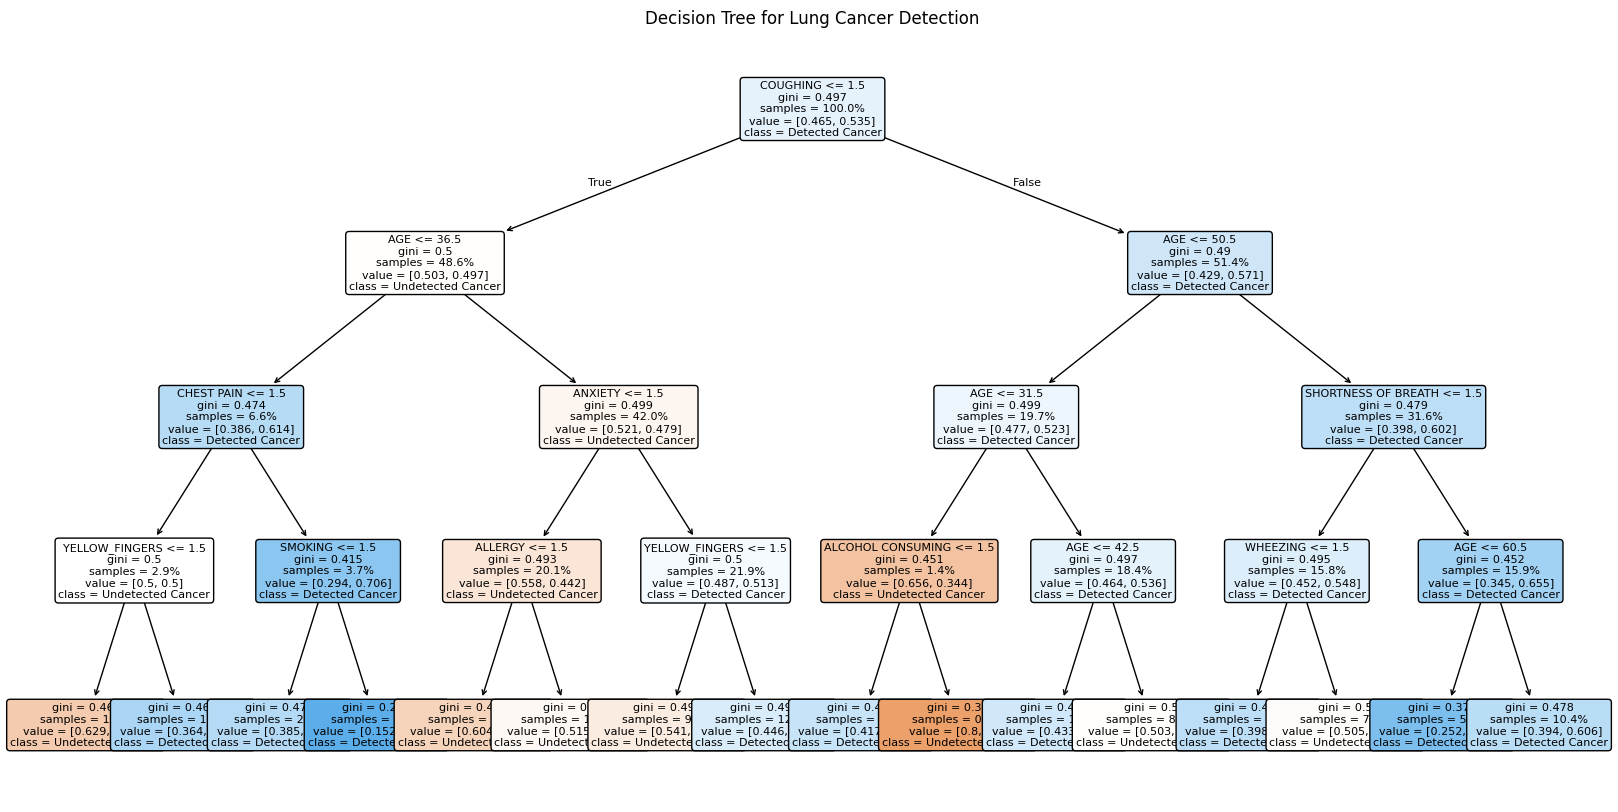

In [57]:
# Decision Tree
dt_model = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
)

dt_model.fit(X_train, y_train)

# Predict on test data
y_pred = dt_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("✅ Model Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

scores = cross_val_score(dt_model, X_train, y_train, cv=5)
print("Cross-Validation Accuracy: {:.2f}%".format(scores.mean() * 100))

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Undetected', 'Detected'],
            yticklabels=['Undetected', 'Detected'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# feature importance plot
importances = dt_model.feature_importances_
features = X.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[sorted_idx], y=features[sorted_idx])
plt.title("Feature Importance (Decision Tree)")
plt.show()


# Decision Tree Graph
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model, 
    filled=True, 
    feature_names=X.columns, 
    class_names=['Undetected Cancer', 'Detected Cancer'],
    proportion=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree for Lung Cancer Detection")
plt.show()


In [ ]:
# SVM


In [ ]:
# Random Forest

